In [1]:
import warnings
warnings.simplefilter("ignore")

In [2]:
from sys import maxsize #para imprimir arrays completos
import numpy as np
import pandas as pd

from sklearn import preprocessing #para normalizar datos
from sklearn.model_selection import train_test_split, KFold
from sklearn.decomposition import PCA

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Para importar notebooks propias

In [3]:
import io, os, sys, types
from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell

In [4]:
def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path

    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        if os.path.isfile(nb_path):
            return nb_path

In [5]:
class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path

    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)

        print ("importing Jupyter notebook from %s" % path)

        # load the notebook object
        with io.open(path, 'r', encoding='utf-8') as f:
            nb = read(f, 4)


        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod

        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__

        try:
          for cell in nb.cells:
            if cell.cell_type == 'code':
                # transform the input to executable Python
                code = self.shell.input_transformer_manager.transform_cell(cell.source)
                # run the code in themodule
                exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod

In [6]:
class NotebookFinder(object):
    """Module finder that locates Jupyter Notebooks"""
    def __init__(self):
        self.loaders = {}

    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return

        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)

        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]

In [7]:
sys.meta_path.append(NotebookFinder())

# Importamos bibliotecas propias

In [8]:
#luego de ejecutar las celdas anteriores, se puede importar la biblioteca propia
#si da errores, probar con hacer restart del kernel
import _02_Anexo_Func as funcs

importing Jupyter notebook from _02_Anexo_Func.ipynb


# Levantamos el Dataframe

In [9]:
pathArchivoDataSet = 'mushrooms.csv' 
mushrooms = pd.read_csv(pathArchivoDataSet)

In [10]:
mushrooms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

##### Comprobamos que el data frame no tiene valores nulos

In [11]:
mushrooms.isna().sum()

class                       0
cap-shape                   0
cap-surface                 0
cap-color                   0
bruises                     0
odor                        0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-root                  0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-type                   0
veil-color                  0
ring-number                 0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
dtype: int64

##### Vemos que todos los valores del dataframe están codificados, usando la referencia del mismo armamos un método para modificar cada código con la palabra correspondiente (en le notebook de funciones auxiliares). Por ejemplo, para la columna 'class' la 'e' es por 'edible' y la 'p' por 'poisonous'

In [12]:
mushrooms.sample(10)

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
3874,p,x,s,g,f,c,f,c,n,n,...,s,w,w,p,w,o,p,n,v,d
146,e,f,f,w,f,n,f,w,b,k,...,f,w,w,p,w,o,e,n,a,g
6455,p,x,s,n,f,f,f,c,n,b,...,k,p,p,p,w,o,e,w,v,p
1539,e,f,s,w,f,n,f,w,b,p,...,s,w,w,p,w,o,e,k,s,g
3396,e,f,f,e,t,n,f,c,b,n,...,s,p,w,p,w,o,p,n,y,d
2256,e,f,y,n,t,n,f,c,b,u,...,s,w,w,p,w,o,p,n,y,d
3761,e,f,f,g,t,n,f,c,b,u,...,s,p,w,p,w,o,p,n,v,d
3747,e,f,y,n,t,n,f,c,b,u,...,s,g,g,p,w,o,p,n,v,d
590,p,x,s,w,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
2390,e,f,f,n,t,n,f,c,b,n,...,s,w,w,p,w,o,p,n,v,d


In [13]:
mushrooms.columns

Index(['class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
       'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
       'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
       'stalk-surface-below-ring', 'stalk-color-above-ring',
       'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number',
       'ring-type', 'spore-print-color', 'population', 'habitat'],
      dtype='object')

##### Modificamos todos los valores que contiene el dataframe, para hacerlos mas compresibles y legibles

In [14]:
funcs.getDescriptForEachColumns(mushrooms)

Este dataframe contiene por cada fila información acerca de  un hongo en particular. Vamos a generar un modelo para clasificar dichos hongos en si son comestibles o no.
La columna que dice si un hongo es comestible, o no, o sea nuestro target para el data set, es la primera ("edible"). Si vale 1 significa que sí es comestible.

In [15]:
mushrooms.head()

,edible,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,0,convex,smooth,brown,1,pungent,free,close,narrow,black,...,smooth,white,white,partial,white,one,pendant,black,scattered,urban
1,1,convex,smooth,yellow,1,almond,free,close,broad,black,...,smooth,white,white,partial,white,one,pendant,brown,numerous,grasses
2,1,bell,smooth,white,1,anise,free,close,broad,brown,...,smooth,white,white,partial,white,one,pendant,brown,numerous,meadows
3,0,convex,scaly,white,1,pungent,free,close,narrow,brown,...,smooth,white,white,partial,white,one,pendant,black,scattered,urban
4,1,convex,smooth,gray,0,none,free,crowded,broad,black,...,smooth,white,white,partial,white,one,evanescent,brown,abundant,grasses


##### Mostramos informacíón básica de todas las columnas del data frame

In [16]:
funcs.getInfoByColumn(mushrooms)

Información columna: edible 
---------------
count    8124.000000
mean        0.517971
std         0.499708
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: edible, dtype: float64
Show Unique  0 1

Información columna: cap-shape 
---------------
count       8124
unique         6
top       convex
freq        3656
Name: cap-shape, dtype: object
Show Unique  'convex' 'bell' 'sunken' 'flat' 'knobbed' 'conical'

Información columna: cap-surface 
---------------
count      8124
unique        4
top       scaly
freq       3244
Name: cap-surface, dtype: object
Show Unique  'smooth' 'scaly' 'fibrous' 'grooves'

Información columna: cap-color 
---------------
count      8124
unique       10
top       brown
freq       2284
Name: cap-color, dtype: object
Show Unique  'brown' 'yellow' 'white' 'gray' 'red' 'pink' 'buff' 'purple' 'cinnamon'
 'green',etc...

Información columna: bruises 
---------------
count    8124.000000
mean        0.415

###### Para obtener un poco más de información, imprimimos un histograma de todas las columnas

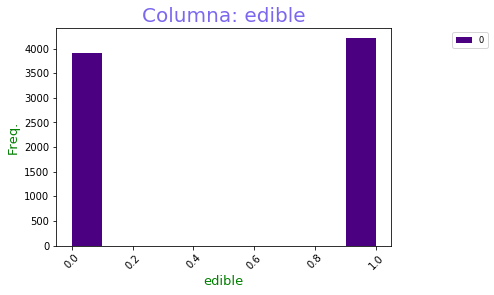

AxesSubplot(0.125,0.125;0.775x0.755)


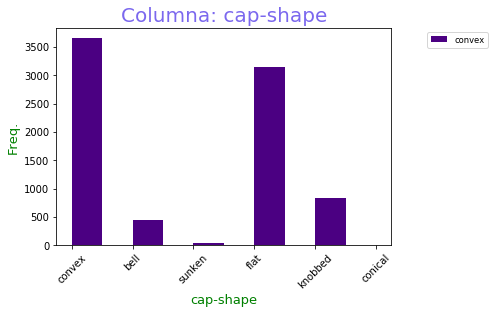

AxesSubplot(0.125,0.125;0.775x0.755)


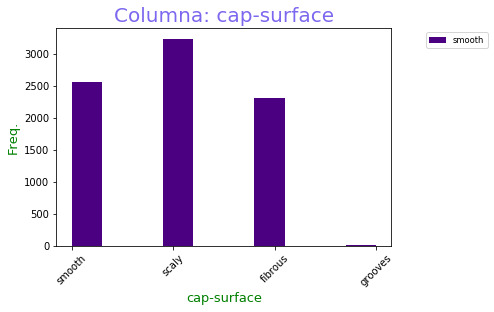

AxesSubplot(0.125,0.125;0.775x0.755)


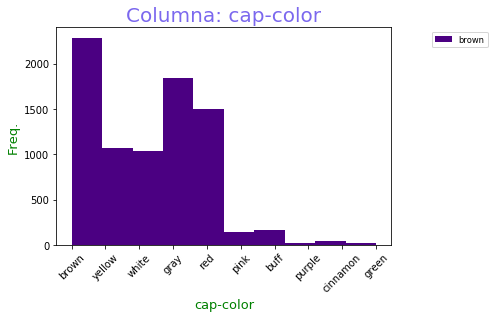

AxesSubplot(0.125,0.125;0.775x0.755)


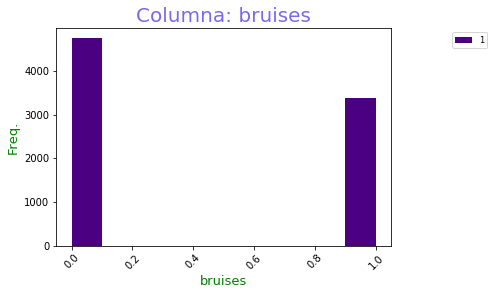

AxesSubplot(0.125,0.125;0.775x0.755)


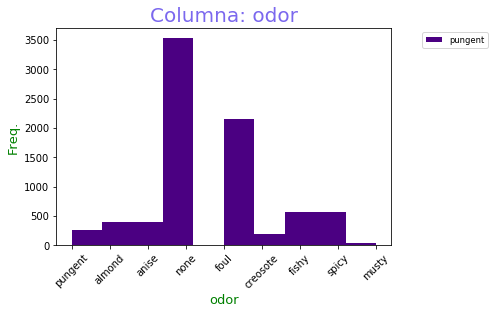

AxesSubplot(0.125,0.125;0.775x0.755)


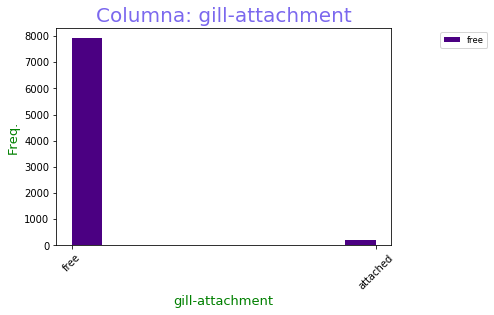

AxesSubplot(0.125,0.125;0.775x0.755)


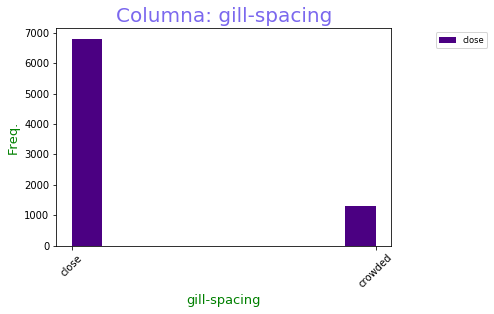

AxesSubplot(0.125,0.125;0.775x0.755)


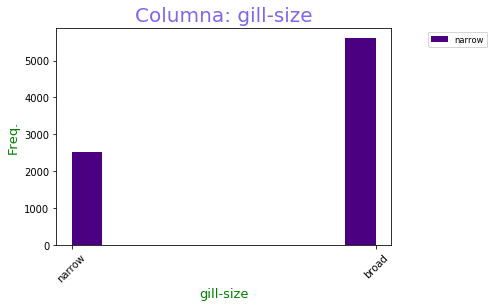

AxesSubplot(0.125,0.125;0.775x0.755)


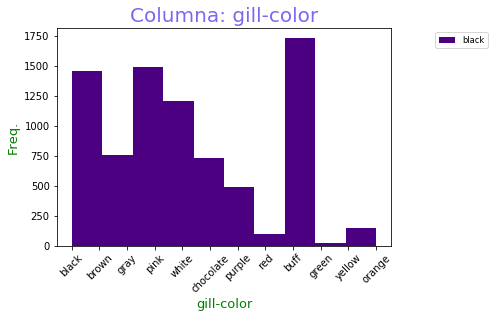

AxesSubplot(0.125,0.125;0.775x0.755)


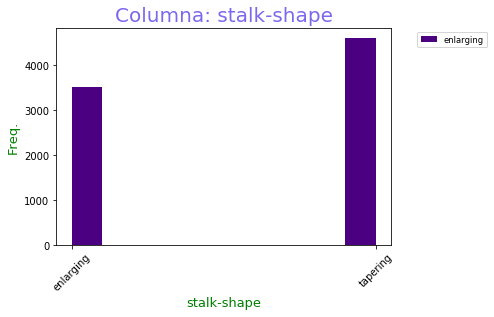

AxesSubplot(0.125,0.125;0.775x0.755)


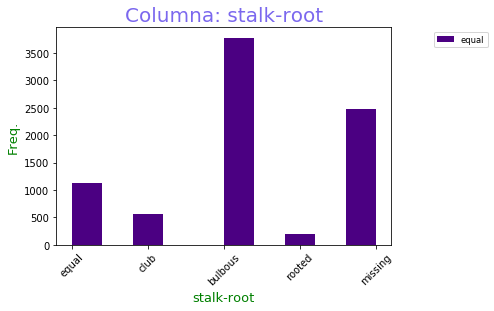

AxesSubplot(0.125,0.125;0.775x0.755)


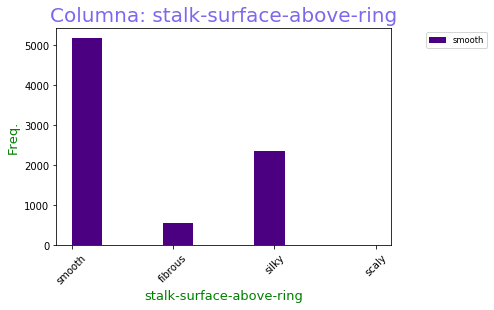

AxesSubplot(0.125,0.125;0.775x0.755)


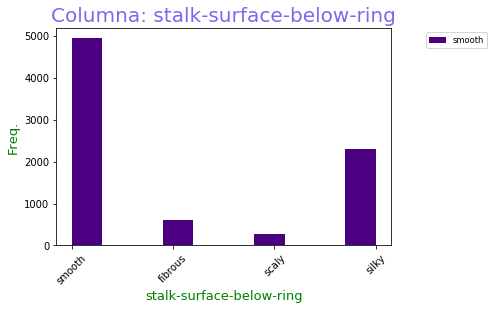

AxesSubplot(0.125,0.125;0.775x0.755)


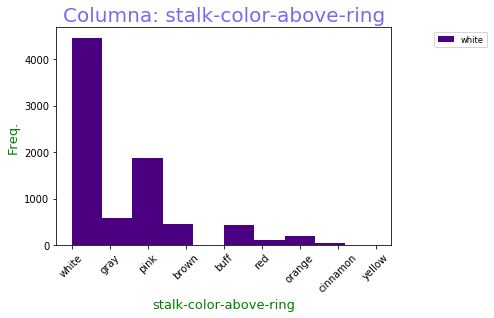

AxesSubplot(0.125,0.125;0.775x0.755)


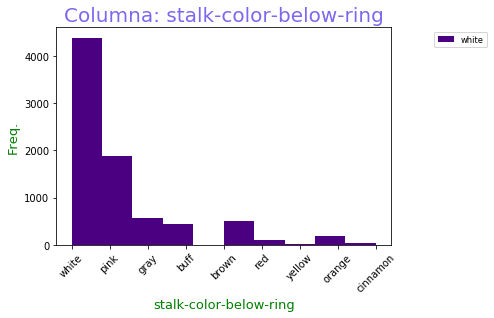

AxesSubplot(0.125,0.125;0.775x0.755)


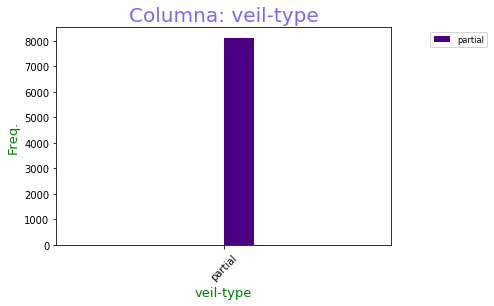

AxesSubplot(0.125,0.125;0.775x0.755)


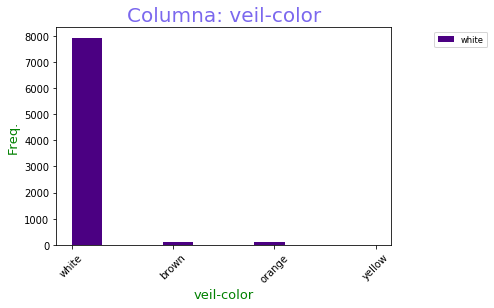

AxesSubplot(0.125,0.125;0.775x0.755)


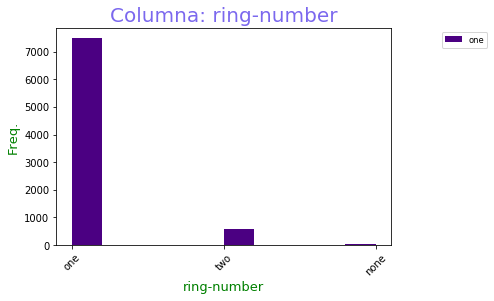

AxesSubplot(0.125,0.125;0.775x0.755)


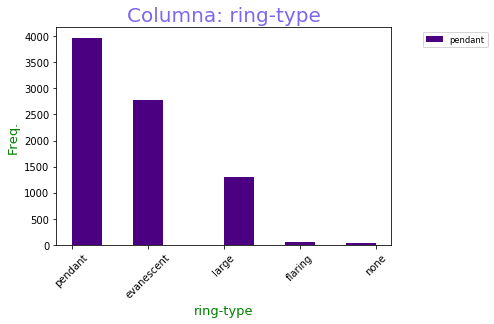

AxesSubplot(0.125,0.125;0.775x0.755)


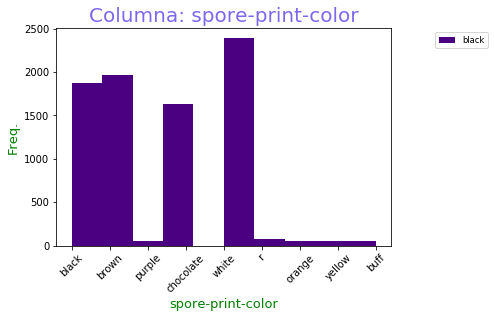

AxesSubplot(0.125,0.125;0.775x0.755)


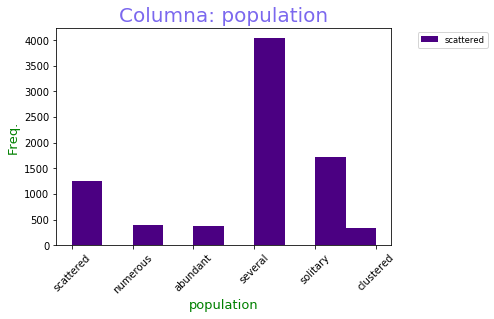

AxesSubplot(0.125,0.125;0.775x0.755)


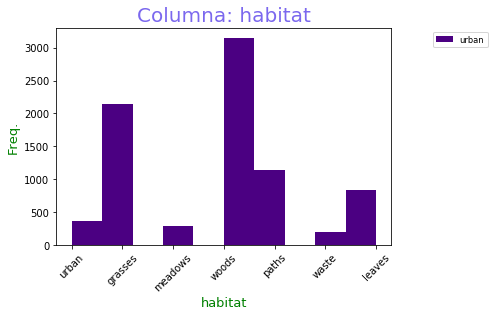

AxesSubplot(0.125,0.125;0.775x0.755)


In [17]:
funcs.getHistogramByColumn(mushrooms)

# Generación de dummies para variables categóricas

In [18]:
# Selección de columnas para Dummies
mushroomsdummies = pd.get_dummies(mushrooms, drop_first=True, columns=mushrooms.columns)
mushroomsdummies

,edible_1,cap-shape_conical,cap-shape_convex,cap-shape_flat,cap-shape_knobbed,cap-shape_sunken,cap-surface_grooves,cap-surface_scaly,cap-surface_smooth,cap-color_buff,...,population_numerous,population_scattered,population_several,population_solitary,habitat_leaves,habitat_meadows,habitat_paths,habitat_urban,habitat_waste,habitat_woods
0,0,0,1,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0
1,1,0,1,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,1,0,0,0,0
3,0,0,1,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
4,1,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,1,0,0,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
8120,1,0,1,0,0,0,0,0,1,0,...,0,0,1,0,1,0,0,0,0,0
8121,1,0,0,1,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
8122,0,0,0,0,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0


# Columnas luego de hacer Dummies
mushroomsdummies.columns

##### Mostramos información estadística para el data set, luego de generar los dummies

In [19]:
funcs.getStatisticForEachColumn(mushroomsdummies)

Statistics mesures from:edible_1
-----------------------------
STD:0.49970767884413053
VAR: 0.2497077642957887
Mean: 0.517971442639094

Statistics mesures from:cap-shape_conical
-----------------------------
STD:0.022185275504213193
VAR: 0.0004921864491978419
Mean: 0.0004923682914820286

Statistics mesures from:cap-shape_convex
-----------------------------
STD:0.49752681392757064
VAR: 0.2475329305769195
Mean: 0.4500246184145741

Statistics mesures from:cap-shape_flat
-----------------------------
STD:0.4873213968679901
VAR: 0.23748214384536911
Mean: 0.3879862136878385

Statistics mesures from:cap-shape_knobbed
-----------------------------
STD:0.30256201029582624
VAR: 0.09154377007425166
Mean: 0.1019202363367799

Statistics mesures from:cap-shape_sunken
-----------------------------
STD:0.06264115289778346
VAR: 0.003923914036363486
Mean: 0.003938946331856229

Statistics mesures from:cap-surface_grooves
-----------------------------
STD:0.02218527550421319
VAR: 0.0004921864491978418
Me

##### Verificamos la correlación entre las datos

In [20]:
mushroomsdummies.head()

,edible_1,cap-shape_conical,cap-shape_convex,cap-shape_flat,cap-shape_knobbed,cap-shape_sunken,cap-surface_grooves,cap-surface_scaly,cap-surface_smooth,cap-color_buff,...,population_numerous,population_scattered,population_several,population_solitary,habitat_leaves,habitat_meadows,habitat_paths,habitat_urban,habitat_waste,habitat_woods
0,0,0,1,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0
1,1,0,1,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,1,0,0,0,0
3,0,0,1,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
4,1,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


# Feature engineering

In [21]:
mushroomsdummies.shape

(8124, 96)

El dataframe luego de generar los dummies de las columnas contiene 95 columnas de features y la colimna objetivo (edible). A continuación haremos un análisis de esos features para ver si se puede prescindir de algunos de ellos

## PCA

##### Aplicamos PCA sobre los dummies para ver si podemos sacar alguna conclusión en cuanto a la cantidad de columnas

In [22]:
df_dummies_features = mushroomsdummies.drop(['edible_1'], axis=1)

In [23]:
pca = PCA()
df_dummies_features_PCA = pca.fit_transform(df_dummies_features)

In [24]:
#mostramos cunánta varianza supone cada uno de los features
explained_variance = pca.explained_variance_ratio_
explained_variance

array([1.82467516e-01, 1.27322679e-01, 9.01887720e-02, 5.21223556e-02,
       4.57384111e-02, 4.41781398e-02, 3.60636105e-02, 2.70468290e-02,
       2.50943347e-02, 2.29254812e-02, 2.06355865e-02, 1.95833346e-02,
       1.85224841e-02, 1.79941225e-02, 1.74101124e-02, 1.57540213e-02,
       1.48070826e-02, 1.43284978e-02, 1.28582738e-02, 1.24102381e-02,
       1.21820575e-02, 1.10163319e-02, 1.08545361e-02, 1.03077458e-02,
       9.86207254e-03, 9.21296580e-03, 9.07631303e-03, 8.90480952e-03,
       8.14103073e-03, 8.03272311e-03, 6.96506975e-03, 6.38890153e-03,
       5.99145534e-03, 5.33763035e-03, 4.48245316e-03, 4.23222395e-03,
       4.13970349e-03, 4.08227538e-03, 3.96537364e-03, 3.30076584e-03,
       3.25337605e-03, 2.88832283e-03, 2.51649299e-03, 2.35028347e-03,
       1.96167523e-03, 1.78908176e-03, 1.71084660e-03, 1.52823599e-03,
       1.36169573e-03, 1.31369636e-03, 1.24995707e-03, 1.16373283e-03,
       1.04667345e-03, 9.79435651e-04, 9.55617381e-04, 9.10567199e-04,
      

##### Vemos que los últimos features aportan un valor muy bajo a la totalidad del conjunto (5.15038965e-05 a 6.37004955e-34, por ejemplo). Teniendo esto en cuenta, podemos considerar que se pueden quitar del conjunto y el entrenamiento de los modelos no se verían muy afectados por esto (en cuanto a la generación de los modelos). El hecho de sacarlos puede agilizar un poco los cálculos y la obtención de los modelos. Para reforzar esta idea realizamos un análisis de correlación a continuación.

## Análisis de correlación

##### Como la cantidad de features es muy grande (95), se dificulta el análisis de una matriz de correlación completa. En su lugar realizamos el análisis de correlaciones directamente contra la variable objetivo 'edible_1'

In [25]:
#generamos la matriz de correlacion para la variable objetivo
matriz_corr = pd.DataFrame(mushroomsdummies.corr()['edible_1'])

In [26]:
matriz_corr

,edible_1
edible_1,1.000000
cap-shape_conical,-0.023007
cap-shape_convex,0.026886
cap-shape_flat,-0.018526
cap-shape_knobbed,-0.163565
...,...
habitat_meadows,0.138627
habitat_paths,-0.323346
habitat_urban,-0.112078
habitat_waste,0.150087


In [27]:
#definimos una variable numerica para seleccionar los features que mas se correlacionan con la variable objetivo
#si features_corr_count == 94, los modelos se van a evaluar con todas las features incluidas
features_corr_count = 30

#hay que sumarle 1 porque se cuenta la columna objetivo
total_columns_corr_count = features_corr_count + 1

In [28]:
#generamos la serie de correlacion contra edible_1, ordenando de mayor a menor segun el aporte
matriz_corr_subset=matriz_corr.abs().sort_values('edible_1',ascending= False).head(total_columns_corr_count)

In [29]:
matriz_corr_subset

,edible_1
edible_1,1.000000
odor_none,0.785557
odor_foul,0.623842
stalk-surface-above-ring_silky,0.587658
stalk-surface-below-ring_silky,0.573524
ring-type_pendant,0.540469
gill-size_narrow,0.540024
gill-color_buff,0.538808
bruises_1,0.501530
stalk-surface-above-ring_smooth,0.491314


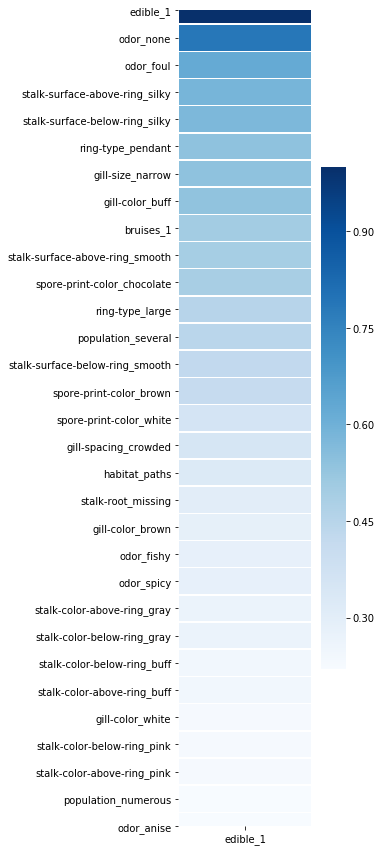

In [30]:
plt.figure(figsize=(3, 15))
sns.heatmap(matriz_corr_subset,linewidths=.5,cmap="Blues")

In [31]:
#tomamos los nombres de los features que mas aportan a la variable objetivo edible_1
feature_names_to_keep = matriz_corr_subset.index.values

In [32]:
feature_names_to_keep

array(['edible_1', 'odor_none', 'odor_foul',
       'stalk-surface-above-ring_silky', 'stalk-surface-below-ring_silky',
       'ring-type_pendant', 'gill-size_narrow', 'gill-color_buff',
       'bruises_1', 'stalk-surface-above-ring_smooth',
       'spore-print-color_chocolate', 'ring-type_large',
       'population_several', 'stalk-surface-below-ring_smooth',
       'spore-print-color_brown', 'spore-print-color_white',
       'gill-spacing_crowded', 'habitat_paths', 'stalk-root_missing',
       'gill-color_brown', 'odor_fishy', 'odor_spicy',
       'stalk-color-above-ring_gray', 'stalk-color-below-ring_gray',
       'stalk-color-below-ring_buff', 'stalk-color-above-ring_buff',
       'gill-color_white', 'stalk-color-below-ring_pink',
       'stalk-color-above-ring_pink', 'population_numerous', 'odor_anise'],
      dtype=object)

In [33]:
print("El DF queda con " + str(len(feature_names_to_keep)) + " columnas:")
print("Una corresponde a la variable objetivo")
print(str(features_corr_count) + " corresponden a la selección de features")

El DF queda con 31 columnas:
Una corresponde a la variable objetivo
30 corresponden a la selección de features


### Actualizamos el df con las columnas que más aportan a la variable objetivo para simplificar un poco los modelos

In [34]:
mushroomsdummies_shortened = mushroomsdummies[feature_names_to_keep]

In [35]:
mushroomsdummies_shortened.head()

,edible_1,odor_none,odor_foul,stalk-surface-above-ring_silky,stalk-surface-below-ring_silky,ring-type_pendant,gill-size_narrow,gill-color_buff,bruises_1,stalk-surface-above-ring_smooth,...,odor_spicy,stalk-color-above-ring_gray,stalk-color-below-ring_gray,stalk-color-below-ring_buff,stalk-color-above-ring_buff,gill-color_white,stalk-color-below-ring_pink,stalk-color-above-ring_pink,population_numerous,odor_anise
0,0,0,0,0,0,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,1,0,0,1,1,...,0,0,0,0,0,0,0,0,1,0
2,1,0,0,0,0,1,0,0,1,1,...,0,0,0,0,0,0,0,0,1,1
3,0,0,0,0,0,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [36]:
mushroomsdummies_shortened.shape

(8124, 31)

# Preparamos el data frame para la generación de los modelos

In [37]:
X = mushroomsdummies_shortened.drop(['edible_1'],axis=1)
X.head()

,odor_none,odor_foul,stalk-surface-above-ring_silky,stalk-surface-below-ring_silky,ring-type_pendant,gill-size_narrow,gill-color_buff,bruises_1,stalk-surface-above-ring_smooth,spore-print-color_chocolate,...,odor_spicy,stalk-color-above-ring_gray,stalk-color-below-ring_gray,stalk-color-below-ring_buff,stalk-color-above-ring_buff,gill-color_white,stalk-color-below-ring_pink,stalk-color-above-ring_pink,population_numerous,odor_anise
0,0,0,0,0,1,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,1,1
3,0,0,0,0,1,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
y = mushroomsdummies_shortened['edible_1']
y.sample(10)

7253    1
2480    1
7962    0
6107    0
5811    0
4113    1
6375    1
2459    1
5943    0
5644    0
Name: edible_1, dtype: uint8

##### Verificamos la distribución de los valores que puede adoptar la variable objetivo

In [39]:
pd.Series(y).value_counts(normalize=True)

1    0.517971
0    0.482029
Name: edible_1, dtype: float64

##### Podemos ver que los valores que puede adoptar nuestra variable objetivo estan muy balanceados, llegando casi a 50% tanto como para edible_1 == 1 (comestible) como para edible_1 == 0 (venenoso, no comestible)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25,random_state=12)

########################################################
con el analisis de PCA vamos a eliminar varias caracteristicas
tener en cuenta bien qué variables eliminamos, por ej un conjunto completo de caracteristicas ej (todas las variables relacionadas al color)

con PCA vamos a eliminar un set de por ej 40 features

luego de aplicar PCA, hacer el analisis de la matriz de correlacion para limpiar aun mas el set de features (nos quedamos con las que mas peso aportan a la variable objetivo) => copiar analisis y graficos de corbatin:
https://www.kaggle.com/nirajvermafcb/comparing-various-ml-models-roc-curve-comparison

agregar los scores a los training de los modelos

analizar el valor absoluto de los coeficientes, para ver cuanto explican al modelo (graficos) => ej si los hongos son rojos no los comas

nuestro modelo debe recomendar con mas seguridad cuando no tiene q comer un hongo, o sea podemos soportar falsos positivos

agregar el analisis de las metricas
* agregar las diferentes funciones
* generar un DF e ir guardando los resultados de los modelos ahi
* tomar ese DF y aplicar las funciones de las metricas => para compara los modelos
* graficar curva ROC comparativa para todos los modelos
########################################################

# Modelo KNN

### Dado que nuestro set de datos consiste en su totalidad de variables dummies, no necesitamos aplicar estandarización en ningún paso del análisis para este modelo. Los datos están todos en la misma escala

##### Buscamos el mejor hiperparámetro K, estandarizando los datos, buscando en un rango para K de 1 a 20. Con un KFold de 10 splits


In [41]:
df_scores = funcs.getScoresForHyperparameterK(quantityK=20, stepK= 1, model_X_train=X_train, model_y_train=y_train, \
                                                kFold_N_Splits=10, KFold_shuffle=True, useStandarization=False)

In [42]:
df_scores

,score_medio,score_std,n_neighbours,limite_inferior,limite_superior
0,0.993598,0.002695,1,0.990904,0.996293
1,0.994912,0.001364,2,0.993548,0.996276
2,0.993762,0.002827,3,0.990936,0.996589
3,0.993434,0.002545,4,0.990889,0.995980
4,0.993435,0.002323,5,0.991111,0.995758
5,0.994748,0.002919,6,0.991830,0.997667
6,0.993270,0.002793,7,0.990477,0.996063
7,0.992778,0.002229,8,0.990548,0.995007
8,0.992777,0.003462,9,0.989316,0.996239
9,0.992942,0.002551,10,0.990391,0.995493


##### Graficamos los resultados para ver los valores obtenidos

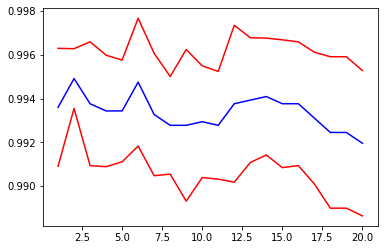

In [43]:
plt.plot(df_scores['n_neighbours'],df_scores['limite_inferior'],color='r', linestyle='--')
plt.plot(df_scores['n_neighbours'],df_scores['score_medio'],color='b')
plt.plot(df_scores['n_neighbours'],df_scores['limite_superior'],color='r', linestyle='--');

##### Mostramos los mejores de acuerdo a los datos (mejore score para el trainning)

In [44]:
df_scores.loc[df_scores.score_medio == df_scores.score_medio.max()]

,score_medio,score_std,n_neighbours,limite_inferior,limite_superior
1,0.994912,0.001364,2,0.993548,0.996276


##### Seleccionamos uno

In [45]:
best_k = df_scores.loc[df_scores.score_medio == df_scores.score_medio.max(),'n_neighbours'].values
best_k = best_k[0]
print('Seleccionado K =', best_k)

Seleccionado K = 2


##### Obtenido el valor para K, procedemos a ver como se comporta el modelo con datos no utilizados en la búsqueda del hiperparámetro K

In [46]:
#obtenemos las predicciones del modelo, utilizando el mejor K obtenido
y_pred, knn_pred_score = funcs.getKNNPredictions(X_train, y_train, X_test, y_test, best_k, useStandarization=False)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')


##### Score KNN para el testing

In [47]:
knn_pred_score

0.9960610536681438

##### Analizamos los resultados con la matriz de confusión

array([ 979,    0,    8, 1044], dtype=int64)

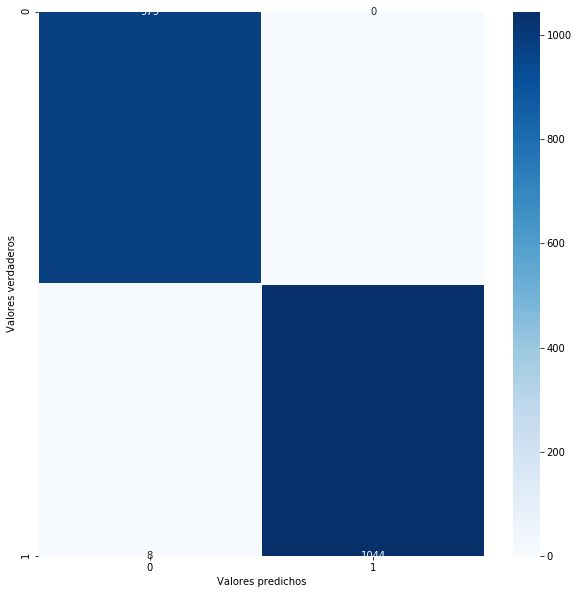

In [48]:
funcs.getConfusionMatrix(y_test, y_pred)

## Curva ROC

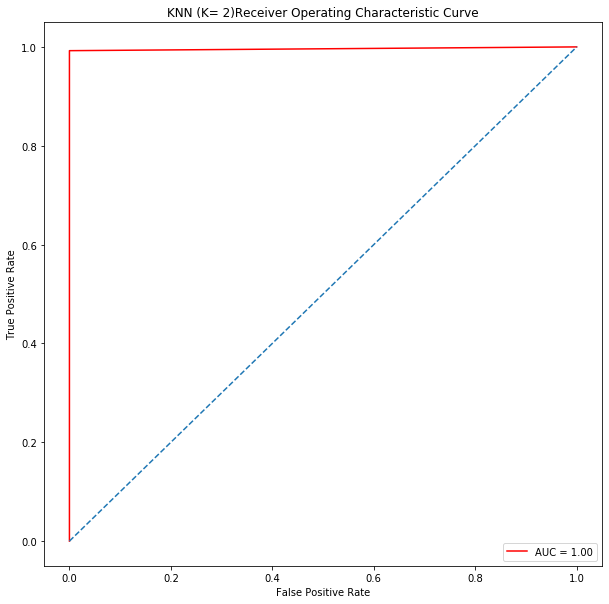

In [49]:
tituloModelo = 'KNN (K= ' + str(best_k) +')'
funcs.plotSingleROC_Curve(tituloModelo, y_test, y_pred)

# Modelo Regresion Logistica


##### Buscamos el mejor hiperparametro C para la regresión

In [50]:
posiblesValoresHiperparametroC = np.linspace(0.0001, 5, 10)

In [51]:
df_scores_rl = funcs.getScoresForHyperparameterC(valoresPosiblesC=posiblesValoresHiperparametroC, model_X_train=X_train, \
                                                 model_y_train=y_train, kFold_N_Splits=5, KFold_shuffle=True, \
                                                 useStandarization=False)

##### Graficamos los resultados para ver los valores obtenidos

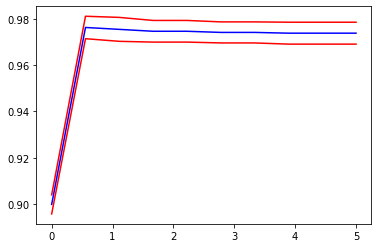

In [52]:
plt.plot(df_scores_rl['C'],df_scores_rl['limite_inferior'],color='r', linestyle='--')
plt.plot(df_scores_rl['C'],df_scores_rl['score_medio'],color='b')
plt.plot(df_scores_rl['C'],df_scores_rl['limite_superior'],color='r', linestyle='--');

##### Mostramos los mejores de acuerdo a los datos (mejor score para el trainning)

In [53]:
df_scores_rl.loc[df_scores_rl.score_medio == df_scores_rl.score_medio.max()]

,score_medio,score_std,C,limite_inferior,limite_superior
1,0.976202,0.004841,0.555644,0.971361,0.981044


##### Seleccionamos uno

In [54]:
best_C = df_scores_rl.loc[df_scores_rl.score_medio == df_scores_rl.score_medio.max(),'C'].values
best_C = best_C[0]
print('Seleccionado C =', best_C)

Seleccionado C = 0.5556444444444445


##### Obtenido el valor para C, procedemos a ver como se comporta el modelo con datos no utilizados en la búsqueda del hiperparámetro C

In [55]:
#obtenemos las predicciones del modelo, utilizando el mejor K obtenido
y_pred_lr, lr_testing_score, lr_coeficientes = funcs.getLogisticRegressionPredictions(X_train, y_train, X_test, y_test, best_C, \
                                                                     useStandarization=False)

LogisticRegression(C=0.5556444444444445, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


##### Peso de los coeficientes

In [56]:
lr_coeficientes

array([[ 3.04136308, -3.25082511, -2.07336396, -0.74816676, -0.6784313 ,
        -2.91224152, -2.19353543,  0.11260395,  0.82450765, -0.81754845,
        -0.82701787, -1.15839375, -0.70706028,  0.93343194, -1.30486139,
         1.79105504,  0.83749652,  1.68633275,  0.99524891, -1.04065756,
        -1.0332385 ,  1.34620338,  1.36876783, -0.19169703, -0.18651288,
         0.25841318,  0.70897132,  0.68774217,  2.20815446,  3.23915796]])

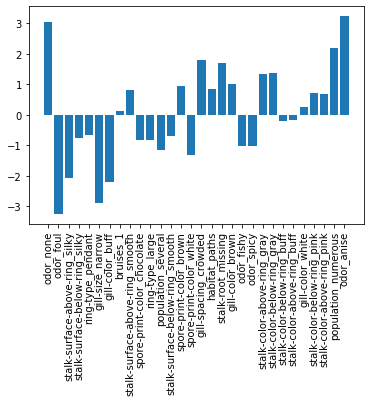

In [57]:
#graficamos el peso de cada uno de los coeficientes del modelo
plt.bar([x for x in range(len(lr_coeficientes[0]))], lr_coeficientes[0],color='orange', linewidth=0.8)
plt.xticks(range(0,features_corr_count), X_train.columns, rotation=90)
plt.show()

##### Score para el testing

In [58]:
lr_testing_score

0.9773510585918267

##### Analizamos los resultados con la matriz de confusión

array([ 953,   26,   20, 1032], dtype=int64)

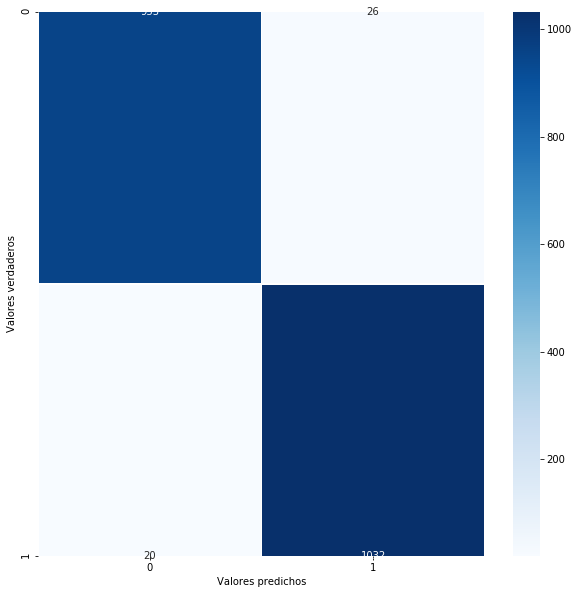

In [59]:
funcs.getConfusionMatrix(y_test, y_pred_lr)

## Curva ROC

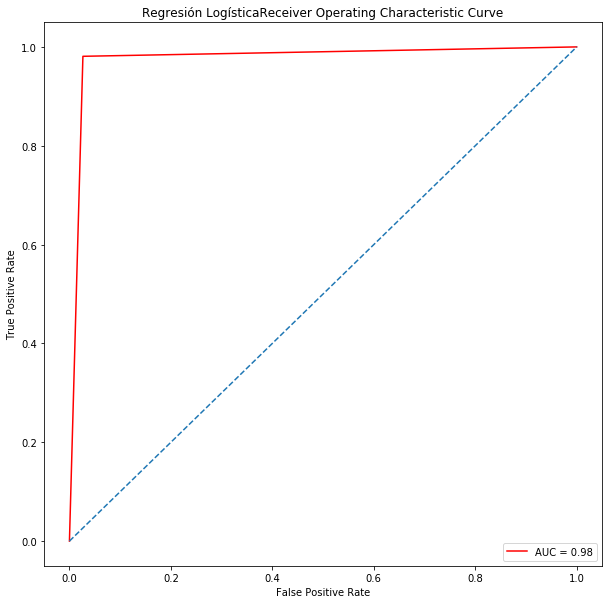

In [60]:
tituloModelo = 'Regresión Logística'
funcs.plotSingleROC_Curve(tituloModelo, y_test, y_pred_lr)

# Modelo Bernouille Naive Bayes

##### Utilizamos un modelo Bernouille Naive Bayes, ya que todas las variables son discretas (son todas dummies que derivan de variables categoricas), que solo adoptan dos valores 1 o 0

##### Buscamos el mejor hiperparametro Alpha para Naive Bayes

In [61]:
posiblesValoresHiperparametroAlpha = np.linspace(0.0001, 10, 40)

In [62]:
df_scores_NB = funcs.getScoresForHypermarameterAlphaNB(valoresPosiblesAlpha=posiblesValoresHiperparametroAlpha, \
                                                        model_X_train=X_train, \
                                                        model_y_train=y_train, kFold_N_Splits=10, KFold_shuffle=True, \
                                                        useStandarization=False)

##### Graficamos los resultados para ver los valores obtenidos

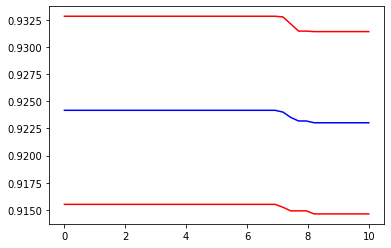

In [63]:
plt.plot(df_scores_NB['Alpha'],df_scores_NB['limite_inferior'],color='r', linestyle='--')
plt.plot(df_scores_NB['Alpha'],df_scores_NB['score_medio'],color='b')
plt.plot(df_scores_NB['Alpha'],df_scores_NB['limite_superior'],color='r', linestyle='--');

##### Mostramos los mejores de acuerdo a los datos (mejor score para el trainning)

In [64]:
df_scores_NB.loc[df_scores_NB.score_medio == df_scores_NB.score_medio.max()]

,score_medio,score_std,Alpha,limite_inferior,limite_superior
0,0.924173,0.008667,0.000100,0.915506,0.93284
1,0.924173,0.008667,0.256508,0.915506,0.93284
2,0.924173,0.008667,0.512915,0.915506,0.93284
3,0.924173,0.008667,0.769323,0.915506,0.93284
4,0.924173,0.008667,1.025731,0.915506,0.93284
5,0.924173,0.008667,1.282138,0.915506,0.93284
6,0.924173,0.008667,1.538546,0.915506,0.93284
7,0.924173,0.008667,1.794954,0.915506,0.93284
8,0.924173,0.008667,2.051362,0.915506,0.93284
9,0.924173,0.008667,2.307769,0.915506,0.93284


##### Seleccionamos uno

In [65]:
best_Alpha = df_scores_NB.loc[df_scores_NB.score_medio == df_scores_NB.score_medio.max(),'Alpha'].values
best_Alpha = best_Alpha[0]
print('Seleccionado Alpha =', best_Alpha)

Seleccionado Alpha = 0.0001


##### Obtenido el valor para C, procedemos a ver como se comporta el modelo con datos no utilizados en la búsqueda del hiperparámetro C

In [66]:
y_pred_NB, NB_score_test = funcs.getBernoulliNaiveBayesPredictions(best_Alpha, X_train, y_train, X_test, y_test)

BernoulliNB(alpha=0.0001, binarize=0.0, class_prior=None, fit_prior=True)


##### Score del testing

In [67]:
NB_score_test

0.931068439192516

array([ 855,  124,   16, 1036], dtype=int64)

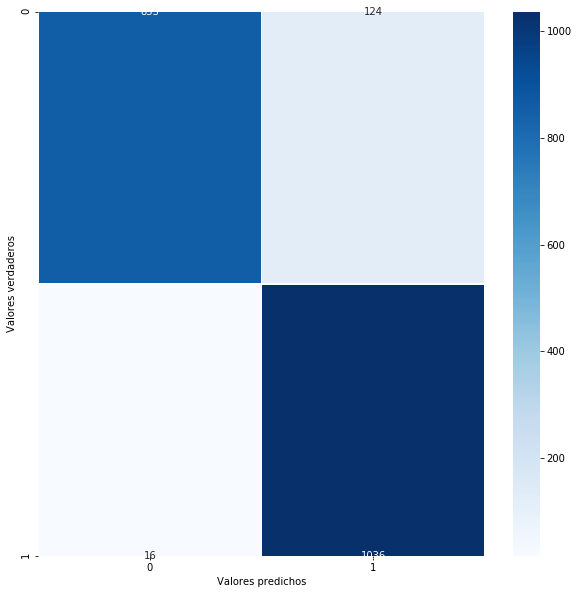

In [68]:
funcs.getConfusionMatrix(y_test, y_pred_NB)

## Curva ROC

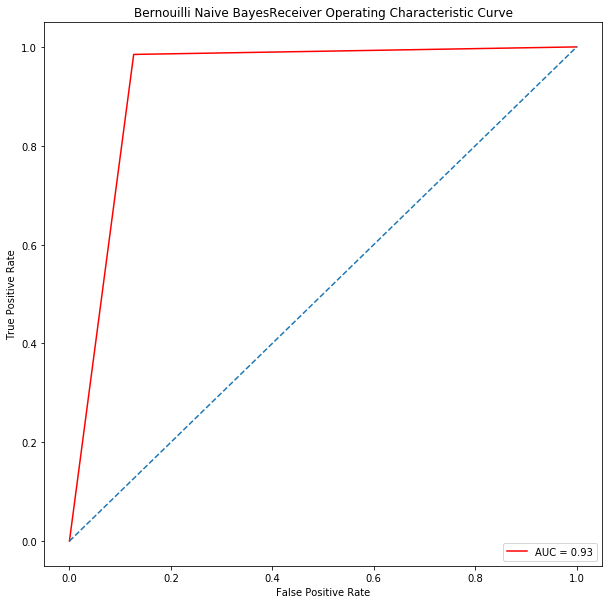

In [69]:
tituloModelo = 'Bernouilli Naive Bayes'
funcs.plotSingleROC_Curve(tituloModelo, y_test, y_pred_NB)

# Modelo Multinomial Naive Bayes

##### Utilizamos un modelo Bernouille Naive Bayes, ya que todas las variables son discretas (son todas dummies que derivan de variables categoricas), que solo adoptan dos valores 1 o 0

##### Buscamos el mejor hiperparametro Alpha para Naive Bayes

In [70]:
posiblesValoresHiperparametroAlpha = np.linspace(0.0001, 10, 40)

In [71]:
df_scores_MNB = funcs.getScoresForHypermarameterAlphaMNB(valoresPosiblesAlpha=posiblesValoresHiperparametroAlpha, \
                                                        model_X_train=X_train, \
                                                        model_y_train=y_train, kFold_N_Splits=10, KFold_shuffle=True, \
                                                        useStandarization=False)

##### Graficamos los resultados para ver los valores obtenidos

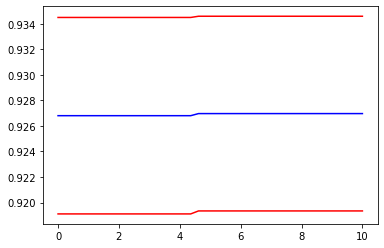

In [72]:
plt.plot(df_scores_MNB['Alpha'],df_scores_MNB['limite_inferior'],color='r', linestyle='--')
plt.plot(df_scores_MNB['Alpha'],df_scores_MNB['score_medio'],color='b')
plt.plot(df_scores_MNB['Alpha'],df_scores_MNB['limite_superior'],color='r', linestyle='--');

##### Mostramos los mejores de acuerdo a los datos (mejor score para el trainning)

In [73]:
df_scores_MNB.loc[df_scores_MNB.score_medio == df_scores_MNB.score_medio.max()]

,score_medio,score_std,Alpha,limite_inferior,limite_superior
18,0.926963,0.007619,4.615438,0.919344,0.934582
19,0.926963,0.007619,4.871846,0.919344,0.934582
20,0.926963,0.007619,5.128254,0.919344,0.934582
21,0.926963,0.007619,5.384662,0.919344,0.934582
22,0.926963,0.007619,5.641069,0.919344,0.934582
23,0.926963,0.007619,5.897477,0.919344,0.934582
24,0.926963,0.007619,6.153885,0.919344,0.934582
25,0.926963,0.007619,6.410292,0.919344,0.934582
26,0.926963,0.007619,6.666700,0.919344,0.934582
27,0.926963,0.007619,6.923108,0.919344,0.934582


##### Seleccionamos uno

In [74]:
best_Alpha = df_scores_MNB.loc[df_scores_MNB.score_medio == df_scores_MNB.score_medio.max(),'Alpha'].values
best_Alpha = best_Alpha[0]
print('Seleccionado Alpha =', best_Alpha)

Seleccionado Alpha = 4.615438461538462


##### Obtenido el valor para C, procedemos a ver como se comporta el modelo con datos no utilizados en la búsqueda del hiperparámetro C

In [75]:
y_pred_MNB, MNB_score_test = funcs.getMultinomialNaiveBayesPredictions(best_Alpha, X_train, y_train, X_test, y_test)

MultinomialNB(alpha=4.615438461538462, class_prior=None, fit_prior=True)


##### Score del testing

In [76]:
MNB_score_test

0.9320531757754801

array([ 855,  124,   14, 1038], dtype=int64)

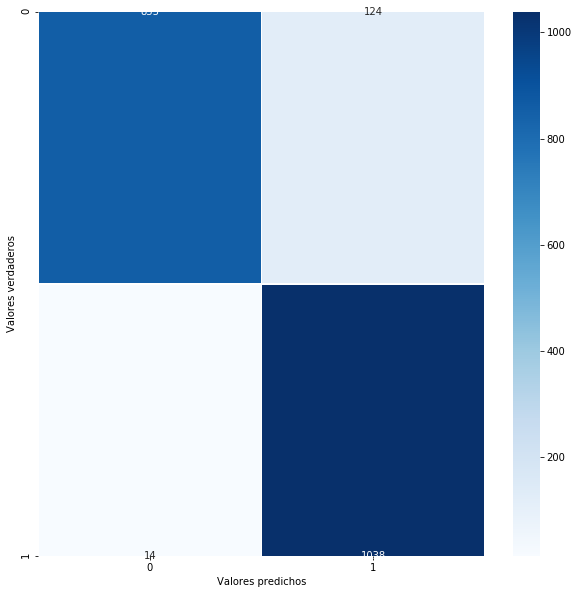

In [77]:
funcs.getConfusionMatrix(y_test, y_pred_MNB)

## Curva ROC

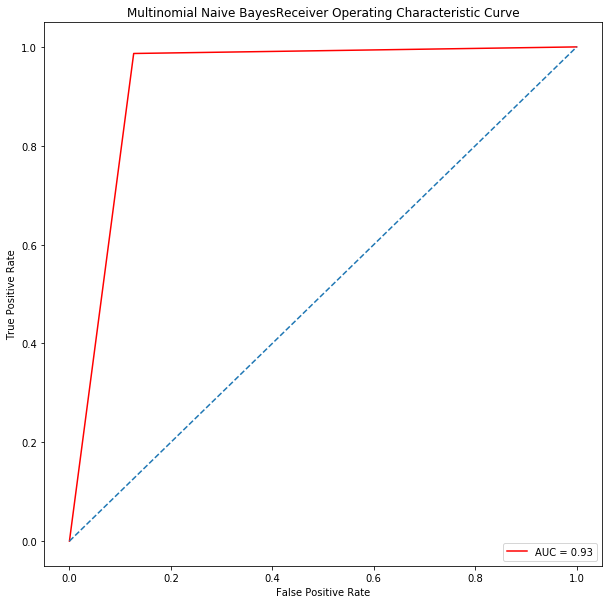

In [78]:
tituloModelo = 'Multinomial Naive Bayes'
funcs.plotSingleROC_Curve(tituloModelo, y_test, y_pred_MNB)

# Comparando todos los modelos

## Curvas ROC

In [79]:
#definimos un array de diccionarios para recopilar la info de todos los modelos para luego pasarla a la función que plotea
#la curva ROC
rocComparisonDictionary = []

#KNN
rocComparisonDictionary.append({"y_prob": y_pred, "modelLabel": "KNN (K="+ str(best_k) +")"})
#regresion logistica
rocComparisonDictionary.append({"y_prob": y_pred_lr, "modelLabel": "Reg Logisitica"})
#Bernoulli Naive Bayes
rocComparisonDictionary.append({"y_prob": y_pred_NB, "modelLabel": "Bernouilli NB"})
#Multinomial Naive Bayes
rocComparisonDictionary.append({"y_prob": y_pred_MNB, "modelLabel": "Multinomial NB"})

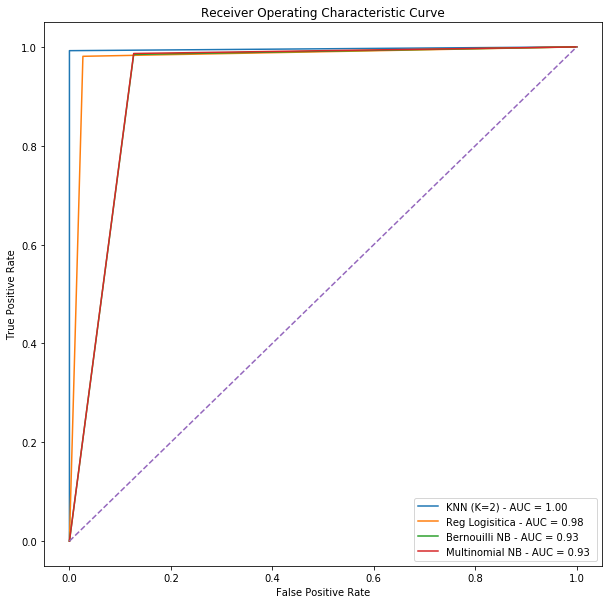

In [80]:
funcs.plotMultipleROC_Curve(y_test, rocComparisonDictionary)

## Análisis de la métrica Precision

##### Dado que para nuestro problema, lo importante es determinar la ingesta de hongos, teniendo en cuenta que un hongo puede comerse si no es venenoso, para el análisis de nuestro modelo debemos tener en cuenta los falsos positivos (FP). Estos casos corresponden a los hongos venenosos (no pueden comerse), pero el modelo los clasificó como comestibles. Lo ideal sería que nuestros modelos minimicen estos casos. Los falsos negativos (FN), corresponden a los hongos marcados por el modelo como no comestibles, siendo que en realidad si pueden comerse; para esta métrica no realizaremos ningún análisis, ya que estos casos no representan ningún peligro si los modelos cometen errores.

##### Para evaluar los modelos usarmos la metrica Precision, ya que penaliza la performance según la cantidad de FP, cuando menor sea el valor de FP, mayor será la Precision

In [86]:
#definimos un  de diccionarios para recopilar la info de todos los modelos 
precisionComparisonDictionary = []

#KNN
precisionComparisonDictionary.append({"precision_score": funcs.getModelPrecision(y_test, y_pred), "model": "KNN (K="+ str(best_k) +")"})
#regresion logistica
precisionComparisonDictionary.append({"precision_score": funcs.getModelPrecision(y_test, y_pred_lr), "model": "Reg Logisitica"})
#Bernoulli Naive Bayes
precisionComparisonDictionary.append({"precision_score": funcs.getModelPrecision(y_test, y_pred_NB), "model": "Bernouilli NB"})
#Multinomial Naive Bayes
precisionComparisonDictionary.append({"precision_score": funcs.getModelPrecision(y_test, y_pred_MNB), "model": "Multinomial NB"})

#lo pasamos a un dataframe
df_precision = pd.DataFrame(precisionComparisonDictionary)

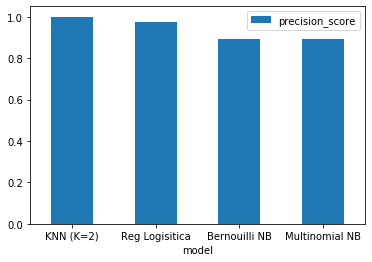

In [89]:
#graficamos los resultados
ax = df_precision.plot.bar(x='model', y='precision_score', rot=0)